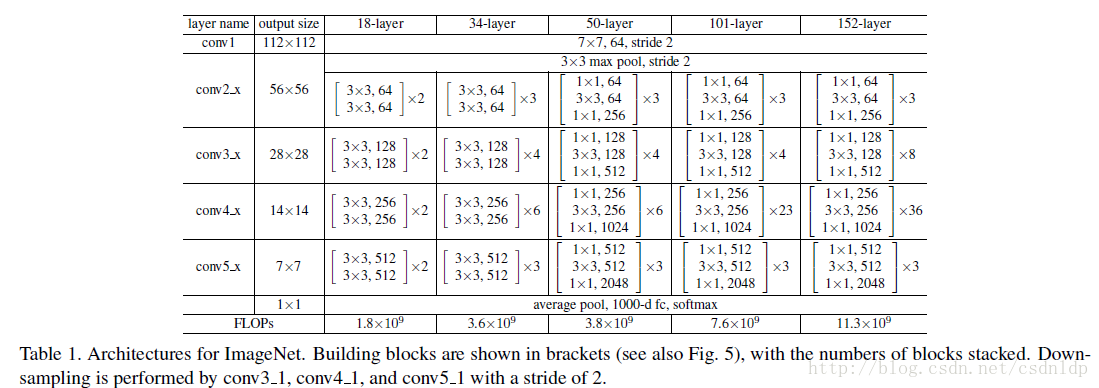

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

In [2]:
# 数据加载
def load(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
fil_1 = 'E:\Download\DigitalImage\cifar-10-batches-py\data_batch_1'
fil_2 = 'E:\Download\DigitalImage\cifar-10-batches-py\data_batch_2'
fil_3 = 'E:\Download\DigitalImage\cifar-10-batches-py\data_batch_3'
fil_4 = 'E:\Download\DigitalImage\cifar-10-batches-py\data_batch_4'
fil_5 = 'E:\Download\DigitalImage\cifar-10-batches-py\data_batch_5'
fil_6 = 'E:\Download\DigitalImage\cifar-10-batches-py\\test_batch_1'

path = [fil_1,fil_2,fil_3,fil_4,fil_5,fil_6]
train_data = []
test_data = []
for i in range(len(path)):
    if i != len(path)-1:
        datas = load(path[i])
        a = datas[b'data'].reshape(10000,3,32,32)
        train_data.append((torch.FloatTensor(a),torch.LongTensor(datas[b'labels'])))
        print()
    else:
        datas = load(path[i])
        test_data = [(torch.FloatTensor(datas[b'data'].reshape(10000,3,32,32)),torch.LongTensor(datas[b'labels']))]

In [3]:
# 残差块定义
class ResBlock(nn.Module):
    
    
    def __init__(self,in_channel,out_channel,stri):
        super(ResBlock,self).__init__()
        self.cov1 = nn.Conv2d(in_channel,out_channel,kernel_size = 3,stride = stri,padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.cov2 = nn.Conv2d(out_channel,out_channel,kernel_size = 3,stride = 1,padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # 恒等映射保证和输出维度一致
        self.identity = nn.Sequential(
             nn.Conv2d(in_channel,out_channel,kernel_size = 1,stride =stri,padding = 0),
             nn.BatchNorm2d(out_channel)
            )
    def forward(self,x):
        out = F.relu(self.cov1(x))
        out = self.bn1(out)
        out = F.relu(self.cov2(out))
        out = self.bn2(out)
        #out = F.relu(self.cov2(out))
        #out = self.bn2(out)
        #out = F.relu(self.cov2(out))
        #out = self.bn2(out)
        #print(self.identity(x).shape,out.shape)
        out = self.identity(x) + out
        out = F.relu(out)
        return out

In [4]:
#测试代码输入伪图片
x = torch.randn(2,3,32,32)
a = ResBlock(3,64,2)
print(a(x).shape)

torch.Size([2, 64, 16, 16])


In [5]:
# 残差块网络连接
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten,self).__init__()
        
    def forward(self,input):
        return input.view(input.size(0),-1)

class Resnet18(nn.Module):
    
    def __init__(self):
        super(Resnet18,self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 3,stride = 1,padding = 1),
            nn.BatchNorm2d(64),
            ResBlock(64,128,stri = 2),
            ResBlock(128,256,stri = 2),
            ResBlock(256,512,stri = 2),
            ResBlock(512,1024,stri = 2),
            nn.AvgPool2d(2),
            Flatten(),
            nn.Linear(1024,10)
        ) 
   
    def forward(self,x):
        return self.model(x)

In [6]:
#测试代码
x = torch.randn(2,3,32,32)
c = Resnet18()
print(c(x).shape)

torch.Size([2, 10])


In [7]:
epochs = 10
device = torch.device('cuda:0')
ResNet18 = Resnet18().to(device)
optimizer = optim.SGD(ResNet18.parameters(),lr = 0.01)
loss_fun = nn.CrossEntropyLoss().to(device)

In [8]:
def Run():
    for epoch in range(epochs):
        ResNet18.train()
        for index,(data,label) in enumerate(train_data):
            for i in range(100):
                datas = data[i:(i+1),:,:,:].to(device)
                #print(datas.shape)
                labels = label[i:(i+1)].to(device)
                #print(labels.shape)
                logits = ResNet18(datas)
                loss = loss_fun(logits,labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print('epoch:{}\t batch:{}\t loss:{}'.format(epoch,index,loss.item()))
        ResNet18.eval()
        loss = 0
        correct = 0
        AVGloss = 0
        for index,(data,label) in enumerate(test_data):
            for i in range(100):
                datas = data[i:i+1,:,:,:].to(device)
                labels = label[i:i+1].to(device)
                logits = ResNet18(datas)
                loss += loss_fun(logits,labels)
                predict = logits.argmax(dim=1)
                correct += predict.eq(labels).float().sum().item()
            loss /= 100.
            print('epochs:{} \t accuracy:{}%\t test_date_AVGloss:{} '.format(epoch,100.*correct/100,loss.item()))
Run()

epoch:0	 batch:0	 loss:1.193771243095398
epoch:0	 batch:1	 loss:0.6211187839508057
epoch:0	 batch:2	 loss:2.3206470012664795
epoch:0	 batch:3	 loss:1.0057952404022217
epoch:0	 batch:4	 loss:1.6052329540252686
epochs:0 	 accuracy:7.0%	 test_date_AVGloss:4.08225154876709 
epoch:1	 batch:0	 loss:1.168436050415039
epoch:1	 batch:1	 loss:0.6469242572784424
epoch:1	 batch:2	 loss:1.9090821743011475
epoch:1	 batch:3	 loss:0.8259971141815186
epoch:1	 batch:4	 loss:1.482107400894165
epochs:1 	 accuracy:7.0%	 test_date_AVGloss:4.174167633056641 
epoch:2	 batch:0	 loss:1.1068801879882812
epoch:2	 batch:1	 loss:0.5857620239257812
epoch:2	 batch:2	 loss:1.4080276489257812
epoch:2	 batch:3	 loss:0.6490111351013184
epoch:2	 batch:4	 loss:1.3858662843704224
epochs:2 	 accuracy:7.0%	 test_date_AVGloss:4.06494140625 
epoch:3	 batch:0	 loss:0.7395391464233398
epoch:3	 batch:1	 loss:0.5753352642059326
epoch:3	 batch:2	 loss:1.252335786819458
epoch:3	 batch:3	 loss:0.41171860694885254
epoch:3	 batch:4	 los

In [9]:
print(len(test_data))

1


In [23]:
# 参数字节数
byte = (9*(3*64+64*64+64*128+128*128+128*256+256*256+256*512+512*512+512*1024+1024*1024)+1024*10)*4
# SGD
sgd_byte = byte
# 保存梯度字节数
print(byte)
grad = byte
# 输入输出显存
put = (3*32*32+32*32*64+64*16*16+128*8*8+256*4*4+512*2*2+1024)*4
print((byte*3+put)/1000000)

75397888
226.595072
